### Importing Libraries

In [1]:
import os
import cv2
import pickle
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.utils import to_categorical

### Reading image Path, Label, Bounding boxes from XML file

In [2]:
BASE_DIR = os.getcwd()
image_dir = os.path.join(BASE_DIR, 'data', 'images')
annot_dir = os.path.join(BASE_DIR, 'data', 'annotations')

In [3]:
label2category = {'without_mask': 0, 'with_mask': 1, 'mask_weared_incorrect': 2}
category2label = {v: k for k, v in label2category.items()}
datas = []

for root, dirs, files in os.walk(annot_dir):
    for file in files:
        tree = ET.parse(os.path.join(root, file))
        data = {'path': None, 'objects': []}
        data['path'] = os.path.join(image_dir, tree.find('filename').text)
        for obj in tree.findall('object'):
            label = label2category[obj.find('name').text]
            # top left co-ordinates
            xmin = int(obj.find('bndbox/xmin').text)
            ymin = int(obj.find('bndbox/ymin').text)
            # bottom right co-ordinates
            xmax = int(obj.find('bndbox/xmax').text)
            ymax = int(obj.find('bndbox/ymax').text)
            data['objects'].append([label, xmin, ymin, xmax, ymax])
        datas.append(data)

print('Total images :', len(datas))

Total images : 853


### What data looks like

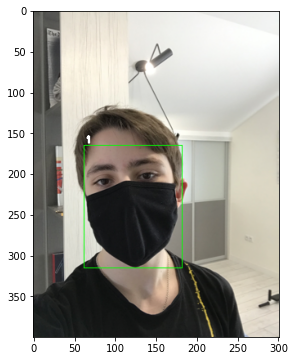

In [4]:
index = np.random.randint(0, len(datas))
img = cv2.imread(datas[index]['path'])
for (category, xmin, ymin, xmax, ymax) in datas[index]['objects']:
    # Draw bounding boxes
    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 1)
    cv2.putText(img, str(category), (xmin+2, ymin-3), cv2.FONT_HERSHEY_SIMPLEX, 0.38, (255,255,255), 2)
# Show image
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

### Get data and target 
Take <b>Region of interest</b> as data(X). 

And target as <b>categorical data</b>. i.e.

    0 -> [1, 0, 0]
    1 -> [0, 1, 0]
    2 -> [0, 0, 1]

In [5]:
img_size = (100, 100)
X = []
Y = []

for data in datas:
    img = cv2.imread(data['path'])
    for (category, xmin, ymin, xmax, ymax) in data['objects']:
        roi = img[ymin : ymax, xmin : xmax]
        roi = cv2.resize(roi, (100, 100))
        data = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
        target = to_categorical(category, num_classes=len(category2label))
        X.append(data)
        Y.append(target)
        
X = np.array(X)
Y = np.array(Y)

In [6]:
np.save('data/X', X)
np.save('data/Y', Y)

In [7]:
with open('data/category2label.pkl', 'wb') as pf:
    pickle.dump(category2label, pf)